<a href="http://www.stfc.ac.uk/"> <img src="../../img/STFCLargeColour.jpg" width="50%" align="left"/></a>
<a href="https://www.addopt.org/"><img src="../../img/ADDoPT-logo-MAIN-with-text.png" width="300" height="200" align="right"/></a>


# An Artificial Neural Net Regressor

We have seen a [neural net classifier](DrugANN.ipynb) and discussed [how neural nets work](Neuron.ipynb). Now, let's use one for a regression problem.

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

import sys, os, time, pickle

import math
import numpy
sys.path.append('../../lib/')
#import rdkit_functions
import models
import pandas  
import pickle

from sklearn.model_selection import train_test_split

from rdkit import Chem

import matplotlib.pyplot as plt
models.hideAnswers
'imported'

/home/vagrant/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Imported models functions


'imported'

## Import the data
This is the data set of log solubilities that we used for [Support Vector Regression](SVR.ipynb).

In [3]:
# log solubilities


with open( "../../model_data/solubility_gm.p", 'rb' ) as f:
    (training_fp, _, y_train, test_fp, _, test_y, _, _) = pickle.load( f )

# convert fingerprints to numpy arrays
training_fp = numpy.array( list(map(numpy.array, training_fp)) )
test_fp = numpy.array( list(map(numpy.array, test_fp)) )
training_fp.shape

(1029, 2048)

(array([384., 138.,  92.,  96.,  72.,  51.,  42.,  52.,  59.,  43.]),
 array([   0. ,  203.6,  407.2,  610.8,  814.4, 1018. , 1221.6, 1425.2,
        1628.8, 1832.4, 2036. ]),
 <a list of 10 Patch objects>)

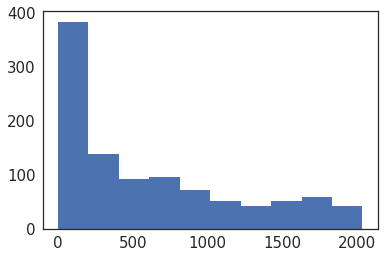

In [11]:
plt.hist( list( map(sum, training_fp) ) )

## Build a Neural Network

### Initializing the Bias
Most fingerprints are sparse. We initialise the bias in the first layer to zeroes, so all separating hyperplanes pass through the origin. Using normal initializer for the first layer makes performance worse.

For later layers, the mean value of the inputs is zero. Initializing the biases to a random value helps find sparse features.

### Initializing the weights
Poggio gives an argument for preferring sparse weights. However, when we try this, the results become worse.


### Noise

TODO exponential noise

Adding noise to the inputs is a way of amplifing the training data. The noise is not used on validation, so in the earlier epochs it causes a fit during training that is worse than the validation fit. As the training reduces the weights of irrelevant features, the error the noise causes reduces, so in later epochs overfitting becomes visible.

If the noise reduces a zero input or increases a unit input, this seems less appropriate. In particular it risks pulling a seperating hyperplane outside the unit hypercube, where the bias can no longer be trained. So we use a custom noise function that always steps towards the centre of the hypercube.


In [41]:
from keras import backend as K
#import numpy as np

class FingerprintNoise(keras.layers.Layer):
    
    def __init__(self, stddev, **kwargs):
        super(FingerprintNoise, self).__init__(**kwargs)
        self.supports_masking = True
        self.stddev = stddev

    def call(self, inputs, training=None):
        # inputs is a tensorflow.python.framework.ops.Tensor
        noise = K.abs( K.random_normal(shape=K.shape(inputs),
                                mean=0.,
                                stddev=self.stddev) )
        #def noised():
        #    return inputs + noise
        return K.in_train_phase(lambda: inputs+noise - 2*inputs*noise, inputs, training=training)

    def get_config(self):
        config = {'stddev': self.stddev}
        base_config = super(FingerprintNoise, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

    pass # end of FingerprintNoise

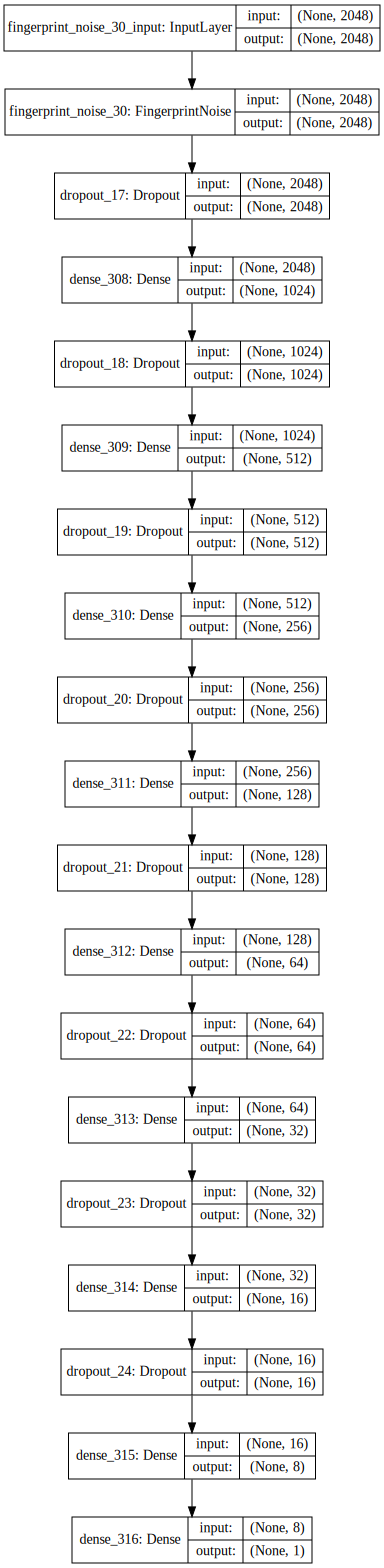

In [96]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LeakyReLU, GaussianNoise

def add_layer(model, size,
             bias_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.005, seed=None),
             kernel_regularizer = keras.regularizers.l1(0.01)
             ):    
    #model.add(Dropout(0.5))  # no
    model.add(Dense(size, activation='relu',  
        kernel_regularizer=kernel_regularizer, # TODO bias_regularizer
        bias_initializer=bias_initializer,
        kernel_initializer=keras.initializers.he_normal()
    )) 

model = Sequential() # multi-layer perceptron 

model.add(FingerprintNoise(0.005, input_shape=(2048,)))  # or dropout 0.2
# with noise 0.001 it learns more slowly

add_layer(model, 1024, bias_initializer = keras.initializers.Zeros())  
add_layer(model, 512)  
add_layer(model, 256)  
add_layer(model, 128)  
add_layer(model, 64)  
add_layer(model, 32)  
add_layer(model, 16)   
add_layer(model, 8)   

model.add(
    Dense(1, activation='linear', 
      kernel_regularizer = None
    )
)  

#optimizer = keras.optimizers.RMSprop(clipnorm=10.0, lr=0.001, rho=0.9, epsilon=None, decay=0.0)
optimizer = keras.optimizers.Adam(clipnorm=10.0, lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error',   
              optimizer = optimizer,
              )

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Train it



In [97]:

history = model.fit(training_fp, 
    y_train,
    batch_size=512,
    epochs=100,
    verbose=1,
    validation_split=0.1,  
    shuffle=True
    #callbacks=[keras.callbacks.EarlyStopping()]
)

Train on 926 samples, validate on 103 samples
Epoch 1/100
926/926 [==============================] - 4s 4ms/step - loss: 733.2987 - val_loss: 699.6976
Epoch 2/100
926/926 [==============================] - 1s 2ms/step - loss: 689.2594 - val_loss: 654.2287
Epoch 3/100
926/926 [==============================] - 1s 1ms/step - loss: 645.1146 - val_loss: 611.3204
Epoch 4/100
926/926 [==============================] - 1s 1ms/step - loss: 602.4925 - val_loss: 570.9451
Epoch 5/100
926/926 [==============================] - 1s 1ms/step - loss: 561.0928 - val_loss: 528.7125
Epoch 6/100
926/926 [==============================] - 1s 2ms/step - loss: 521.3533 - val_loss: 491.4385
Epoch 7/100
926/926 [==============================] - 1s 1ms/step - loss: 483.7859 - val_loss: 456.3249
Epoch 8/100
926/926 [==============================] - 1s 1ms/step - loss: 448.1136 - val_loss: 420.2090
Epoch 9/100
926/926 [==============================] - 1s 2ms/step - loss: 413.9039 - val_loss: 388.0039
Epoch 10/

Epoch 79/100
926/926 [==============================] - 1s 1ms/step - loss: 15.1394 - val_loss: 15.5597
Epoch 80/100
926/926 [==============================] - 1s 1ms/step - loss: 14.5234 - val_loss: 13.9686
Epoch 81/100
926/926 [==============================] - 1s 1ms/step - loss: 14.1551 - val_loss: 14.6553
Epoch 82/100
926/926 [==============================] - 1s 1ms/step - loss: 14.4158 - val_loss: 14.2890
Epoch 83/100
926/926 [==============================] - 1s 1ms/step - loss: 14.0228 - val_loss: 14.1669
Epoch 84/100
926/926 [==============================] - 1s 1ms/step - loss: 13.9066 - val_loss: 13.8761
Epoch 85/100
926/926 [==============================] - 1s 1ms/step - loss: 13.8960 - val_loss: 14.1264
Epoch 86/100
926/926 [==============================] - 2s 2ms/step - loss: 13.7737 - val_loss: 13.6343
Epoch 87/100
926/926 [==============================] - 3s 3ms/step - loss: 13.4147 - val_loss: 13.5943
Epoch 88/100
926/926 [==============================] - 1s 1ms/s

## Display the results

R Squared 0.44564528010239557


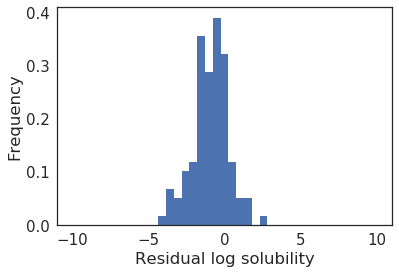

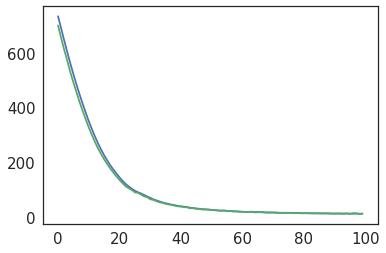

In [98]:

from sklearn import metrics

pr = model.predict(test_fp)  
# that's a list of one-element lists, so extract the data we want
predicted = list(map(lambda lst: lst[0], pr ) )
print('R Squared', metrics.r2_score(test_y, predicted))

residuals = test_y -  predicted

plt.figure()
plt.xlabel('Residual log solubility' )
plt.ylabel('Frequency')
plt.hist(residuals, bins=numpy.linspace(-10, 10, 40), normed=1)
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## Fine tune with Stochastic Gradient Descent
Lower learning rate, and less regularization, since we are now near a minimum. We can also use more noise.

In [94]:

model2 = Sequential() # multi-layer perceptron 

# TODO more or less noise, compared to first training
model2.add(FingerprintNoise(0.05, input_shape=(2048,))) 

add_layer(model2, 1024, kernel_regularizer=None)  
model.add(Dropout(0.1)) 
add_layer(model2, 512, kernel_regularizer=keras.regularizers.l1(0.005)) 
model.add(Dropout(0.1))  
add_layer(model2, 256, kernel_regularizer=keras.regularizers.l1(0.005))  
model.add(Dropout(0.1)) 
add_layer(model2, 128, kernel_regularizer=keras.regularizers.l1(0.005))  
model.add(Dropout(0.1)) 
add_layer(model2, 64, kernel_regularizer=keras.regularizers.l1(0.005))  
model.add(Dropout(0.1)) 
add_layer(model2, 32, kernel_regularizer=keras.regularizers.l1(0.005))  
model.add(Dropout(0.1)) 
add_layer(model2, 16, kernel_regularizer=keras.regularizers.l1(0.005))  
model.add(Dropout(0.1)) 
add_layer(model2, 8, kernel_regularizer=keras.regularizers.l1(0.005))  

model2.add(
    Dense(1, activation='linear', 
      kernel_regularizer=None
    )
)  
model2.set_weights(model.get_weights())


#optimizer = keras.optimizers.RMSprop(clipnorm=10.0, lr=0.001, rho=0.9, epsilon=None, decay=0.0)
optimizer2 = keras.optimizers.SGD(
    lr=0.001, # learning rate
    clipnorm=10.0,
    momentum=0.9, decay=0.01, 
    nesterov=True  # TODO reconsider
)
model2.compile(loss='mean_squared_error',   
              optimizer = optimizer2,
              )


history2 = model2.fit(training_fp,  
    y_train,
    batch_size=512,
    epochs=50,
    verbose=1,
    validation_split=0.1,  
    shuffle=True
    #callbacks=[keras.callbacks.EarlyStopping()]
)


Train on 926 samples, validate on 103 samples
Epoch 1/50
926/926 [==============================] - 3s 3ms/step - loss: 4.8742 - val_loss: 5.1946
Epoch 2/50
926/926 [==============================] - 1s 931us/step - loss: 4.8069 - val_loss: 5.2674
Epoch 3/50
926/926 [==============================] - 1s 930us/step - loss: 4.5980 - val_loss: 5.1270
Epoch 4/50
926/926 [==============================] - 1s 932us/step - loss: 4.4412 - val_loss: 5.1264
Epoch 5/50
926/926 [==============================] - 1s 982us/step - loss: 4.4115 - val_loss: 5.0738
Epoch 6/50
926/926 [==============================] - 2s 2ms/step - loss: 4.3458 - val_loss: 5.0154
Epoch 7/50
926/926 [==============================] - 1s 1ms/step - loss: 4.2681 - val_loss: 4.9480
Epoch 8/50
926/926 [==============================] - 1s 1ms/step - loss: 4.2234 - val_loss: 4.8921
Epoch 9/50
926/926 [==============================] - 1s 1ms/step - loss: 4.1495 - val_loss: 4.8448
Epoch 10/50
926/926 [=========================

R Squared 0.7414995427011105


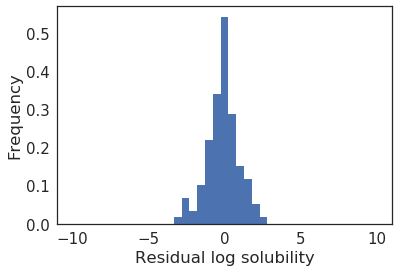

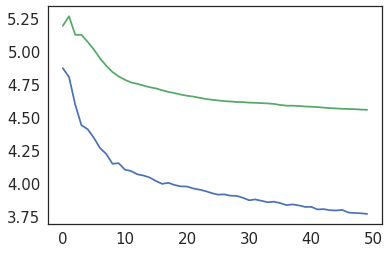

In [95]:

pr = model2.predict(test_fp)  
# that's a list of one-element lists, so extract the data we want
predicted = list(map(lambda lst: lst[0], pr ) )
print('R Squared', metrics.r2_score(test_y, predicted))

residuals = test_y -  predicted

plt.figure()
plt.xlabel('Residual log solubility' )
plt.ylabel('Frequency')
plt.hist(residuals, bins=numpy.linspace(-10, 10, 40), normed=1)
plt.show()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

## Check sparsity

In [56]:
sum( sum( 0==w for w in nw) for nw in model2.get_weights()[2])


0



<div class="alert alert-warning" role="alert">
**Exercise:**<br>
<ul>
    <li>Try with more or less regularization</li>
    <li>Replace the first hidden layer with a PReLU. Are the results better?</li>
As before with the classifier, for the regressor:
    <li>Try varying the learning rate</li>
</ul></div>



[Up](../Welcome.ipynb)<br> [Neural Net Classifier](DrugANN.ipynb) <br>
[Exercise](TrainingNN.ipynb)
[Classical Statistics](Optional/ClassicalStatistics.ipynb)<br>
[Next](TestClassifierModel.ipynb)

---------------------------------------------------
Copyright STFC 2018